# Averaging EIS Spectral Data using EISPAC

### Introduction

This notebook demonstrates how to average spectral data from the EUV Imaging Spectrometer (EIS) instrument using the EISPAC package. We will focus on the Fe XII 195.12 Å line and learn how to:

1. Read and fit EIS data using EISPAC
2. Define a region of interest for averaging
3. Create a custom function to average spectral data within the defined region
4. Apply the averaging function to the EIS data
5. Analyze and visualize the averaged spectral data

### Prerequisites

Before starting, make sure you have the following packages installed:

- eispac
- astropy
- matplotlib
- numpy
- scipy

### Reading and Fitting EIS Data

We begin by importing the necessary packages and reading the EIS data cube using EISPAC's `read_cube` function, specifying the wavelength of interest (195.119 Å).



In [531]:
import eispac

# Replace this with your own data
data_cube = eispac.read_cube('/Users/andysh.to/Script/Python_Script/spice/comp_mosaic_2024/eis_20240327_224050.head.h5', 195.119)

Data file,
   /Users/andysh.to/Script/Python_Script/spice/comp_mosaic_2024/eis_20240327_224050.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/spice/comp_mosaic_2024/eis_20240327_224050.head.h5
Found a wavelength 195.12 [Angstroms] in window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Next, we fit the spectral data using EISPAC's fit_spectra function and a predefined template for the Fe XII 195.119 Å line. The resulting fit is used to create an intensity map.

In [530]:
tmplt_loc = eispac.data.get_fit_template_filepath("fe_12_195_119.2c.template.h5")
tmplt = eispac.read_template(tmplt_loc)
fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max')
fexii_map = fit_res.get_map(component=0, measurement='intensity')

 + computing fits for 60 exposures, each with 160 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 052

Finished computing fits!
   runtime : 0:00:06.193649
   9440 spectra fit without issues
   160 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/andysh.to/miniconda3/envs/spice/lib/python3.9/site-packages/eispac/core/fit_spectra.py:422: RuntimeWarning: invalid value encountered in true_divide
  rel_err = obs_errs/obs_cent


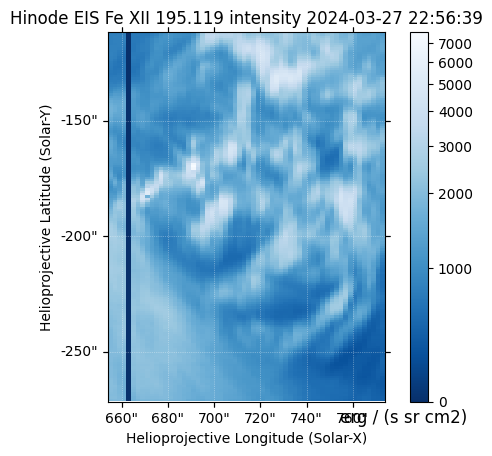

In [388]:
fexii_map.peek()

### Defining the Region of Interest

To define the region of interest for averaging, we specify the lower-left and upper-right coordinates in arcsec.


In [396]:
lower_left = [720,-130] # [x-arcsec, y-arcsec]
upper_right = [740, -140] # [x-arcsec, y-arcsec]

We can visualize the defined region on the intensity map using matplotlib.


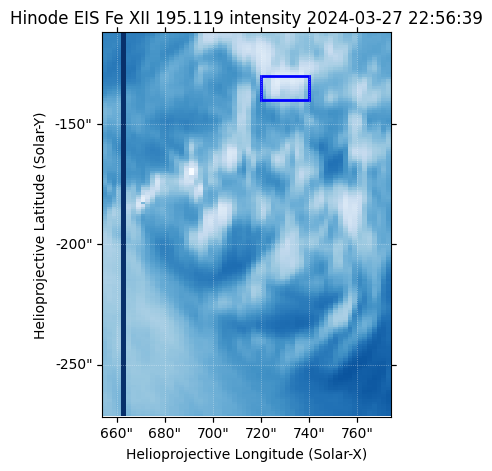

In [399]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection=fexii_map)
fexii_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)

coords = SkyCoord(
    Tx=(lower_left[0], upper_right[0]) * u.arcsec,
    Ty=(lower_left[1], upper_right[1]) * u.arcsec,
    frame=fexii_map.coordinate_frame,
)
fexii_map.draw_quadrangle(
    coords,
    axes=ax,
    edgecolor="blue",
    linestyle="-",
    linewidth=2,
)

### Creating the Averaging Function

We define a custom function called average_spectral_data that takes the data cube, template, and region of interest coordinates as input. The function performs the following steps:

1. Crops the data cube to the specified region of interest
2. Calculates the mean wavelength and averaged error within the region
3. Rebins the cropped data into a single macropixel
4. |Returns the averaged spectral data as a new NDCube object



In [520]:
def average_spectral_data(data_cube, template, lower_left, upper_right, shift2fexii = True, ref_wave=195.12):

    from scipy.ndimage import shift as shift_img
    from eispac.instr.ccd_offset import ccd_offset

    """Average spectral data within a specified rectangular region.

    Parameters:
    - data_cube (ndcube.NDCube): The input data cube containing spectral data.
    - template (dict): A dictionary representing the template with 'data_x' key containing wavelength values.
    - lower_left (list): The lower-left corner coordinates of the rectangular region [x, y].
    - upper_right (list): The upper-right corner coordinates of the rectangular region [x, y].

    Returns:
    - data_cutout_sum (ndcube.NDCube): The averaged spectral data within the specified region,
      rebinned into a single macropixel.
    """

    eis_frame = wcs_to_celestial_frame(data_cube.wcs)
    print(eis_frame)
    
    if shift2fexii:
        this_wave = np.mean(min(tmplt.template['data_x']))
        disp = ccd_offset(ref_wave) - ccd_offset(this_wave)
        print(f'SHIFT2WAVE: shifted to {ref_wave} FOV according to CCD offset - OFFSET: {disp[0]:.1f}')
    else:
        disp = 0
        
    lower_left = [SpectralCoord(min(tmplt.template['data_x']), unit=u.angstrom),
                  SkyCoord(Tx=lower_left[0], Ty=int(lower_left[1]+disp), unit=u.arcsec, frame=eis_frame)]
    upper_right = [SpectralCoord(max(tmplt.template['data_x']), unit=u.AA),
                   SkyCoord(Tx=upper_right[0], Ty=int(upper_right[1]+disp), unit=u.arcsec, frame=eis_frame)]
    

    # Crop ndcube data to the desired subpixels
    data_cutout = data_cube.crop(lower_left, upper_right)
    
    # Calculate the mean wavelength
    wavelength_average = np.nanmean(data_cutout.wavelength, axis=(0, 1))

    # Calculate the averaged error
    sum_squared_errors = np.nansum(data_cutout.uncertainty.array**2, axis=(0, 1))
    
    # Calculate the averaged error by taking the square root of the sum of squared errors divided by the number of elements
    num_elements = data_cutout.data.shape[0] * data_cutout.data.shape[1]
    averaged_error = np.sqrt(sum_squared_errors / num_elements)

    # Rebin data into 1 single pixel - default is np.mean
    data_cutout_sum = data_cutout.rebin(np.array([data_cutout.data[:,0,0].shape[0],data_cutout.data[0,:,0].shape[0],1]))

    # fit everything into the final 1 macropixel datacube
    data_cutout_sum.uncertainty = [[averaged_error]]
    data_cutout_sum.wavelength = np.array([[wavelength_average]])

    return data_cutout_sum

### Applying the Averaging Function

We apply the `average_spectral_data` function to our EIS data cube and the defined region of interest.


In [521]:
data_cutout_average = average_spectral_data(data_cube, tmplt, lower_left, upper_right)

<Helioprojective Frame (obstime=None, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (3.40943654e-15, -6.73692299, 1.49308213e+11)>)>
SHIFT2WAVE: shifted to 195.12 FOV according to CCD offset - OFFSET: -0.0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [522]:
data_cutout_averaged

NDCube
------
Dimensions: [ 1.  1. 13.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('em.wl',)]
Unit: erg / (s sr cm2)
Data Type: float64

The resulting data_cutout_average is a new NDCube object containing the averaged spectral data within the specified region.

### Analyzing the Averaged Spectral Data

We can now use EISPAC's `fit_spectra` function to fit the averaged spectral data.


In [523]:
averaged_fit_res = eispac.fit_spectra(data_cutout_averaged, tmplt, ncpu='max')

 + computing fits for 1 exposures, each with 1 spectra
 + running mpfit on 1 cores (of 12)
 + working on exposure 001

Finished computing fits!
   runtime : 0:00:14.552423
   1 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters


To obtain the averaged intensity, we can directly access the data from the fit results.
EISpac always output map structure. But for 1 macropixel, a map is not very useful. So we can get the intensity by pulling the data directly

In [524]:
averaged_intensity = averaged_fit_res.get_map(component=0, measurement='intensity')
print(f'Averaged Intensity: {averaged_intensity.data[0][0]}')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Averaged Intensity: 3141.496666529729


We can also apply calibration to the averaged intensity using the `calib_2023` function from the `eis_calibration` package.


In [525]:
from eis_calibration.eis_calib_2023 import calib_2023

In [526]:
averaged_intensity_2023 = calib_2023(averaged_intensity)
print(f'Averaged Intensity after calibration: {averaged_intensity_2023.data[0][0]}')

Averaged Intensity after calibration: 5154.247095054429


### Visualizing the Results

Finally, we can visualize the averaged spectral data and its fit profile using matplotlib.


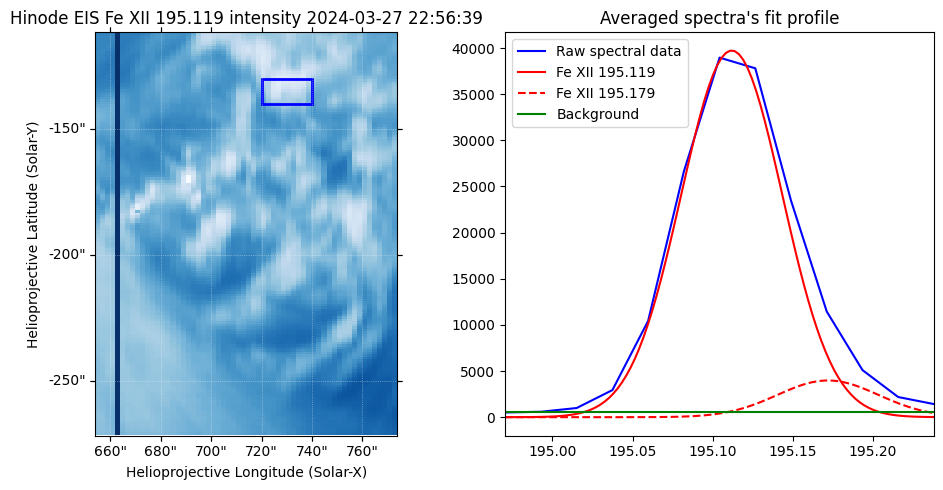

In [527]:
from astropy.visualization import wcsaxes

fig = plt.figure(figsize=(10, 5))

# Create the left subplot with WCSAxes
ax1 = fig.add_subplot(1, 2, 1, projection=fexii_map.wcs)

# Plot the first figure in the left subplot
fexii_map.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent)
coords = SkyCoord(
    Tx=(lower_left[0], upper_right[0]) * u.arcsec,
    Ty=(lower_left[1], upper_right[1]) * u.arcsec,
    frame=fexii_map.coordinate_frame,
)
fexii_map.draw_quadrangle(
    coords,
    axes=ax1,
    edgecolor="blue",
    linestyle="-",
    linewidth=2,
)

# Create the right subplot
ax2 = fig.add_subplot(1, 2, 2)

# Plot the second figure in the right subplot
ax2.plot(data_cutout_averaged[0,0,:].wavelength, data_cutout_averaged[0,0,:].data, color='b', label='Raw spectral data')
c0_x, c0_y = averaged_fit_res.get_fit_profile(0, coords=[0,0], num_wavelengths=100)
c1_x, c1_y = averaged_fit_res.get_fit_profile(1, coords=[0,0], num_wavelengths=100)
c2_x, c2_y = averaged_fit_res.get_fit_profile(2, coords=[0,0], num_wavelengths=100)

ax2.plot(c0_x, c0_y, color='r', label=a.fit['line_ids'][0])
ax2.plot(c1_x, c1_y, color='r', ls='--', label=a.fit['line_ids'][1])
ax2.plot(c2_x, c2_y, color='g', label='Background')

ax2.set_title("Averaged spectra's fit profile")
ax2.set_xlim(min(c0_x), max(c1_x))
ax2.legend()

plt.tight_layout()
plt.show()